In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
standardize = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

train_data = datasets.MNIST(root='data/', train=True, transform=standardize, download=False)
test_data = datasets.MNIST(root='data/', train=False, transform=standardize, download=False)

batch_size = 32
# 32가 아니면 train 안 됨
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def showImg(img):   
    plt.imshow(img)
    plt.show()

torch.Size([1, 50])


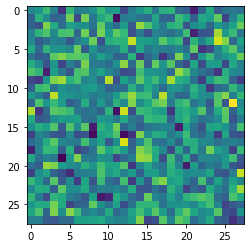

torch.Size([28, 28])


In [4]:
d_noise  = 50
d_hidden = 256

# torch.randn으로 만든 dump data
def fakeImg(batch_size=1, d_noise=50):
    return torch.randn(batch_size, d_noise)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# Make Noise
z = fakeImg()
# Put into Generator
print(z.size())
img_fake = G(z).view(1, 28, 28)
# If not .view(1, 28, 28), just bunch of (.784) data
showImg(img_fake.squeeze().detach().numpy())
print(img_fake.squeeze().size())
# If not detach, can't call numpy that requires grad

In [5]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    # nn.ReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    # nn.ReLU(),
    # nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
    # to use BCELoss
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)).item())

torch.Size([1, 784])
torch.Size([1, 1])
0.4855196177959442


In [6]:
criterion = nn.BCELoss()
def train(G, D, optim_G, optim_D):
    G.train()
    D.train()
    
    for batch, idx in train_dataloader:
        img, label = batch.to(device), idx.to(device)
        
        # optimizer for Discriminator on
        optim_D.zero_grad()
        # reshape해서 28*28 사이즈로 넣어준다
        correct = D(img.view(-1, 28*28))
        wrong = D(G(fakeImg(batch_size, d_noise)))
        # D는 correct일 때, 1에 가깝게 나올 수 있도록 하자
        # D should maxV(D, G) = logD(x) + log(1-D(G(z)))
        # 위 식에서 첫번째 항
        loss_correct = torch.log(correct)
        # 위 식에서 두번째 항
        loss_wrong = torch.log(1.0-wrong)
        # 이 둘을 최대로 만들어야 한다.
        
        # loss를 최소로 하는 방향으로 학습을 진행하므로, -1을 곱해본다.
        # loss_D = (-1)*(loss_correct+loss_wrong)
        # 나중에 .mean 추가해보기
        loss_D = criterion(correct, torch.ones_like(correct).to(device)) + criterion(wrong, torch.zeros_like(wrong).to(device))
        loss_D.backward()
        # grad는 scalar에만 생성이 가능하므로, loss.backward()가 아니라
        # 인자로 loss_D를 backward에 넣어주어야 한다
        # loss_D.backward(loss_D)
        optim_D.step()
    
        # optimizer on for Generator
        optim_G.zero_grad()
        # correct는 만들 필요가 없음
        wrong = D(G(fakeImg(batch_size, d_noise)))
        # minV(D, G) = log(1-D(G(z)))
        # loss_G = torch.log(1.0-wrong)
        # loss_G = -1 * torch.log(wrong)으로 해보기
        loss_G = criterion(wrong, torch.ones_like(wrong).to(device))
        loss_G.backward()
        # loss_G.backward(loss_G)
        optim_G.step()
        
        

In [7]:
correct_batch_list = []
wrong_batch_list = []

def evaluate(G, D):
    correct_sum, wrong_sum = 0.0, 0.0
    G.eval()
    D.eval()
    
    for batch, idx in test_dataloader:
        img, label = batch.to(device), idx.to(device)
        
        with torch.autograd.no_grad():
            correct = (torch.sum(D(img.view(-1, 28*28))).item())
            wrong = (torch.sum(D(G(fakeImg(batch_size, d_noise)))).item())
            correct_batch_list.append(correct)
            wrong_batch_list.append(wrong)     
            
            correct_sum += correct/10000.0
            wrong_sum += wrong/10000.0
            # MNIST testset은 10000개
            # MNIST traingset은 60000개로 이루어져있음
    return correct_sum, wrong_sum

(epoch 30/300) correct: 0.655650, generated: 0.262028


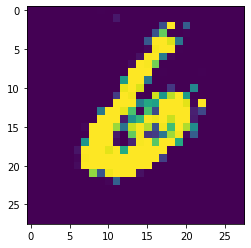

(epoch 60/300) correct: 0.699027, generated: 0.246138


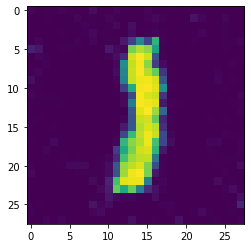

(epoch 90/300) correct: 0.662626, generated: 0.256359


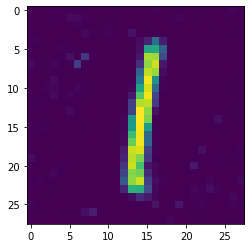

(epoch 120/300) correct: 0.707985, generated: 0.250513


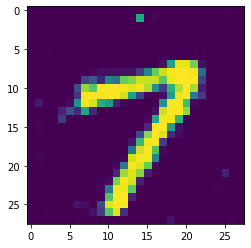

(epoch 150/300) correct: 0.653727, generated: 0.202150


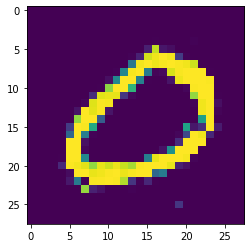

(epoch 180/300) correct: 0.709071, generated: 0.230945


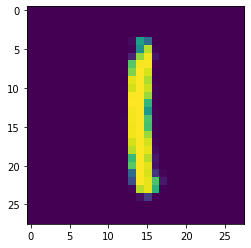

(epoch 210/300) correct: 0.723652, generated: 0.206565


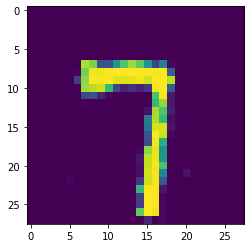

KeyboardInterrupt: 

In [8]:
"""
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)
"""

# lr=0.1, lr=0.01 tried
optim_G = optim.Adam(G.parameters(), lr=0.001)
optim_D = optim.Adam(D.parameters(), lr=0.001)

correct_epoch_list = []
wrong_epoch_list = []

for epoch in range(300):

    train(G, D, optim_G, optim_D)
    correct, wrong = evaluate(G,D)
    
    correct_epoch_list.append(correct)
    wrong_epoch_list.append(wrong)
    
    if((epoch+1)% 30 == 0):
        print('(epoch %i/300) correct: %f, generated: %f' % (epoch+1, correct, wrong))
        z = fakeImg()
        img_fake = G(z).view(1, 28, 28)
        showImg(img_fake.squeeze().detach())
        

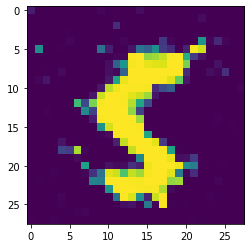

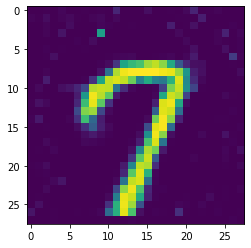

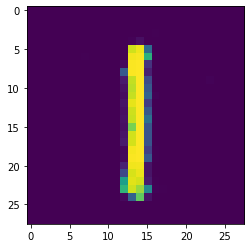

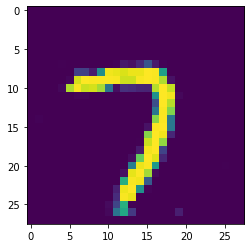

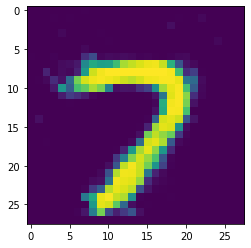

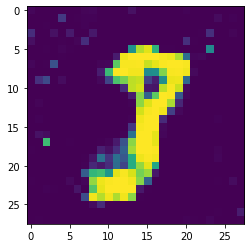

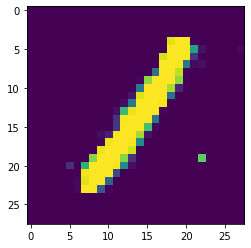

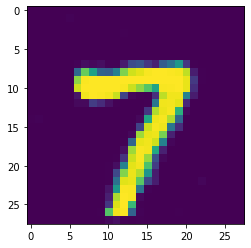

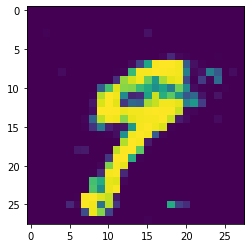

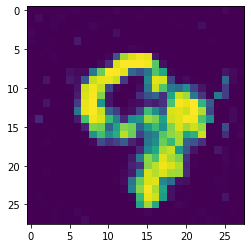

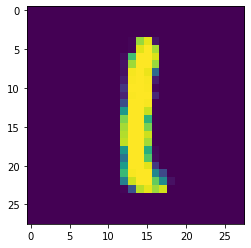

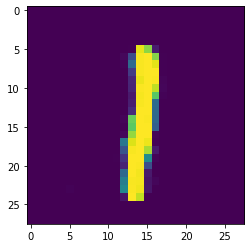

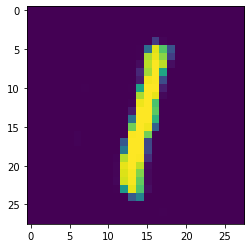

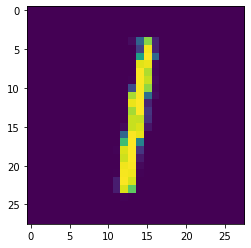

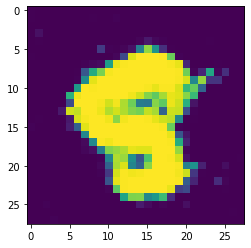

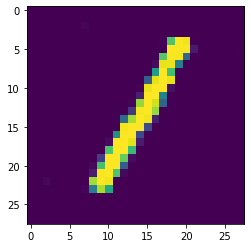

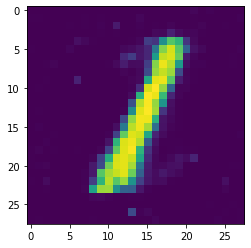

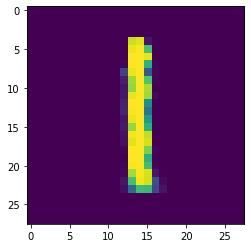

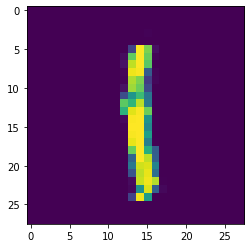

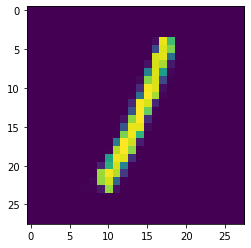

In [19]:
for i in range(20):
    z = fakeImg()
    img_fake = G(z).view(1, 28, 28)
    showImg(img_fake.squeeze().detach())

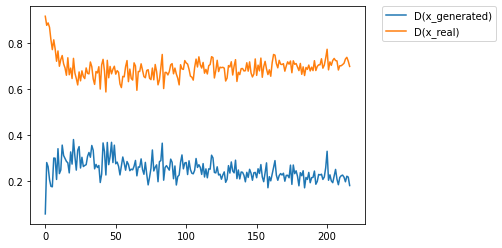

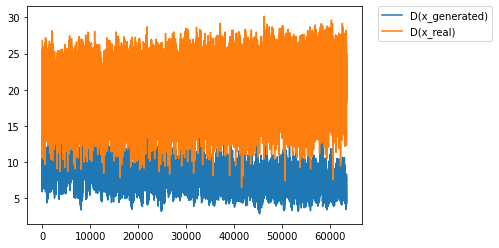

In [14]:
plt.plot(wrong_epoch_list[2:], label='D(x_generated)')
plt.plot(correct_epoch_list[2:], label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

plt.plot(wrong_batch_list[5000:], label='D(x_generated)')
plt.plot(correct_batch_list[5000:], label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()